In [61]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [62]:
df = pd.read_csv("./dataset/uber.csv")
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [63]:
df.dtypes

Unnamed: 0             int64
key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

## 1.Preprocessing ##

In [65]:
# Drop NaN values
df.dropna()

# Remove invalid fare
df = df[(df['fare_amount'] > 0) & (df['passenger_count'] > 0)]

## Feature Engineering ##

In [67]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['hour'] = df['pickup_datetime'].dt.hour
df['day'] = df['pickup_datetime'].dt.day
df['month'] = df['pickup_datetime'].dt.month

In [68]:
# Calculate travel distance (Haversine formula)
def haversine(lon1, lat1, lon2, lat2):
    R = 6371  # Earth radius in km
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1  
    dlat = lat2 - lat1  
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

df['distance'] = haversine(df['pickup_longitude'], df['pickup_latitude'],
                           df['dropoff_longitude'], df['dropoff_latitude'])

df = df[(df['distance'] > 0) & (df['distance'] < 130)] 

## 2 Outlier Identification ##

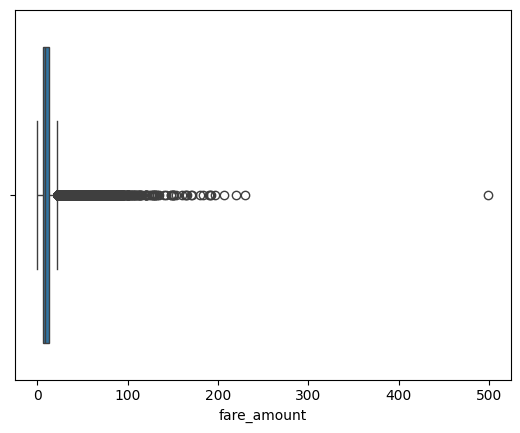

In [70]:
sns.boxplot(x=df['fare_amount'])
plt.show()

In [71]:
# Remove the fare larger than 100
df = df[df['fare_amount'] < 100]


## 3. Correlation ##

Unnamed: 0          -0.000251
fare_amount          1.000000
pickup_longitude     0.012200
pickup_latitude     -0.008798
dropoff_longitude    0.010754
dropoff_latitude    -0.008967
passenger_count      0.013034
hour                -0.020557
day                  0.000604
month                0.024580
distance             0.805653
Name: fare_amount, dtype: float64


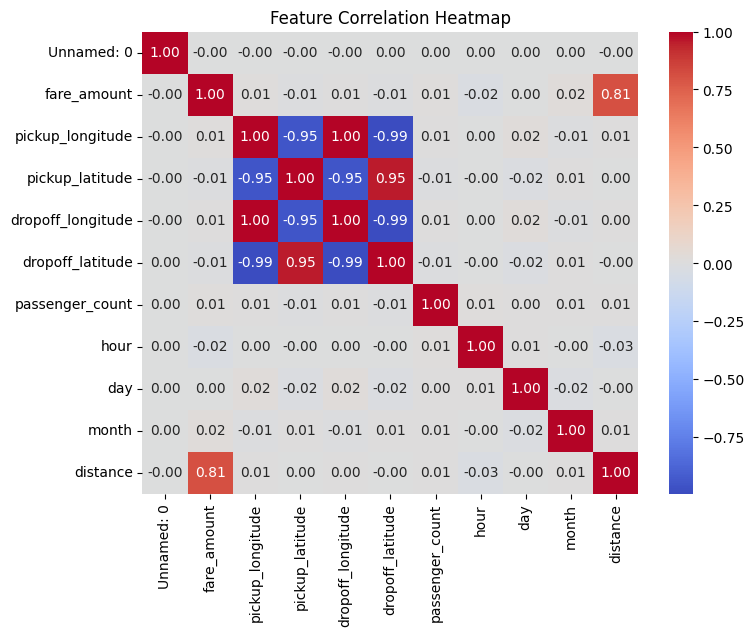

In [73]:
corr = df.corr(numeric_only=True)
print(corr['fare_amount'])

# Heatmap for correlation
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()

## 4. linear regression and random forest ##

In [75]:
# Features and target
# Improved feature selection:
X = df[['pickup_latitude', 'pickup_longitude',
        'dropoff_latitude', 'dropoff_longitude',
        'distance', 'hour', 'passenger_count']]
y = df['fare_amount']

In [76]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [77]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

In [78]:
# Random Forest Regression
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

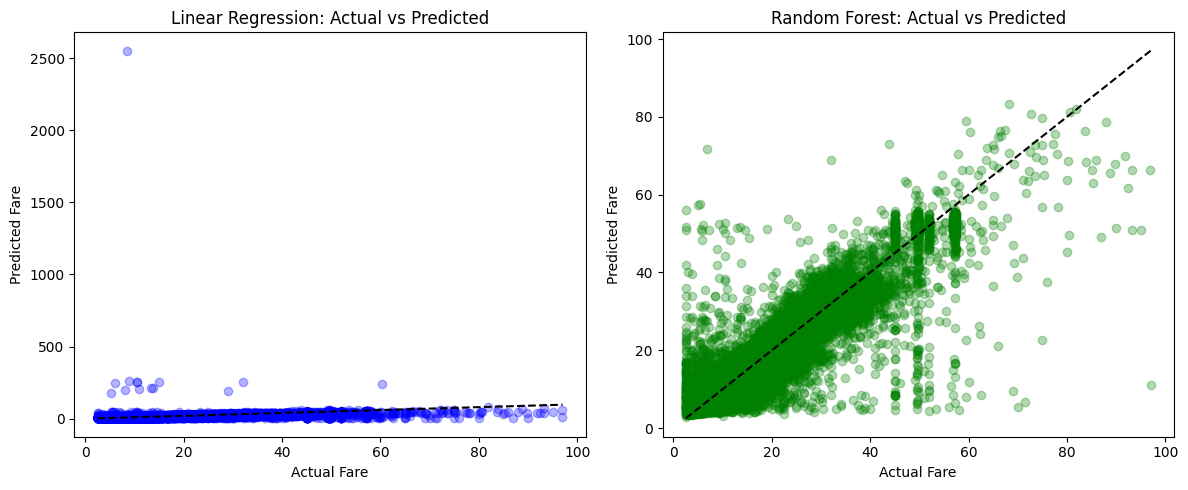

In [79]:
plt.figure(figsize=(12, 5))

# Linear Regression
plt.subplot(1,2,1)
plt.scatter(y_test, y_pred_lr, alpha=0.3, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('Actual Fare')
plt.ylabel('Predicted Fare')
plt.title('Linear Regression: Actual vs Predicted')

# Random Forest
plt.subplot(1,2,2)
plt.scatter(y_test, y_pred_rf, alpha=0.3, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('Actual Fare')
plt.ylabel('Predicted Fare')
plt.title('Random Forest: Actual vs Predicted')

plt.tight_layout()
plt.show()

## 5.Evaluation ##

In [81]:
# Evaluation
print("Linear Regression R2:", r2_score(y_test, y_pred_lr))
print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print("Random Forest R2:", r2_score(y_test, y_pred_rf))
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))

Linear Regression R2: -0.9234417620177524
Linear Regression RMSE: 12.890231348154666
Random Forest R2: 0.8428667941992272
Random Forest RMSE: 3.6843016179643007
